<a href="https://colab.research.google.com/github/ShaliniR8/lahman-mlb/blob/main/combined_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import preprocessing
from sklearn import compose
from sklearn import impute
from sklearn import decomposition
from sklearn import model_selection
from sklearn import tree
from sklearn.utils import compute_class_weight
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn import pipeline

In [3]:
%%capture
!pip install xgboost

In [4]:
import xgboost as xgb

In [5]:
#@title Load Dataset

%%capture
# ---- filtered (only from 1910) 
# !wget https://github.com/ShaliniR8/lahman-mlb/raw/main/baseballdatabase.zip
# !unzip /content/baseballdatabase.zip -d "/content/"


#---- full
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/baseballdatabank_2022.zip
!unzip /content/baseballdatabank_2022.zip -d "/content/"

path = "/content/baseballdatabank-2022.2/core/"



In [6]:
batting = pd.read_csv(path + "Batting.csv")
pitching = pd.read_csv(path + "Pitching.csv")
people = pd.read_csv(path + "People.csv")
# fielding = pd.read_csv(path + "Fielding.csv")
teams = pd.read_csv(path + "Teams.csv")

## Dataset

In [7]:
batting = batting[["playerID","yearID","teamID", "H", "BB", "HBP", "AB", "SF", "2B", "3B", "HR"]].copy()
pitching = pitching[["playerID","yearID","teamID", "ERA"]].copy()
people = people[['playerID', 'birthYear']].copy()
teams = teams[['teamID', 'yearID', 'W', 'L']].copy()
all_dfs = { 
    'batting': batting,
    'pitching': pitching,
    'people':people,
    # 'fielding':fielding,
    'teams':teams
}

## Cleaning

In [8]:

def cleanX(X):
  categorical_features = X.select_dtypes("object").columns.to_list()
  numerical_features = X.select_dtypes(["int64", "float64"]).columns.to_list()
  knnImp = impute.KNNImputer(missing_values=np.nan)
  simpleImp = impute.SimpleImputer(strategy = 'median', missing_values=np.nan)
  Ximputer = compose.ColumnTransformer([
    ('categorical', knnImp, categorical_features),
    ('numerical', simpleImp, numerical_features)
  ])
  X_ = Ximputer.fit_transform(X)

  return X_

In [9]:
for name,df in all_dfs.items():
  not_keys = list(set(df.columns.to_list()) - {'teamID', 'playerID'})
  keys = list(set(df.columns.to_list()) - set(not_keys))
  imputedX = pd.DataFrame(cleanX(df[not_keys]), columns = not_keys, dtype='int64')
  all_dfs[name] = pd.concat([df[keys], imputedX], axis = 1)
  print(name)
  print(all_dfs[name].info())
  


batting
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110495 entries, 0 to 110494
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   playerID  110495 non-null  object
 1   teamID    110495 non-null  object
 2   3B        110495 non-null  int64 
 3   BB        110495 non-null  int64 
 4   H         110495 non-null  int64 
 5   HBP       110495 non-null  int64 
 6   SF        110495 non-null  int64 
 7   AB        110495 non-null  int64 
 8   HR        110495 non-null  int64 
 9   yearID    110495 non-null  int64 
 10  2B        110495 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 9.3+ MB
None
pitching
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49430 entries, 0 to 49429
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   playerID  49430 non-null  object
 1   teamID    49430 non-null  object
 2   yearID    49430 non-null  int64 
 3   ERA    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version, passing float-dtype values and an integer dtype to DataFrame will retain floating dtype if they cannot be cast losslessly (matching Series behavior). To retain the old behavior, use DataFrame(data).astype(dtype)
  after removing the cwd from sys.path.


## Constructing Features

No need to run this after the feature is already constructed 

In [56]:
def win_perc(team, year):
    team_year = teams[(teams['yearID'] == year) & (teams['teamID'] == team)]
    if team_year.empty:
        return np.nan
    team_year = team_year.iloc[0]
    w = team_year['W']
    l = team_year['L']
    return w / (w + l)


def get_rolling_win_perc (row):
    year = row['yearID']
    team = row['teamID']
    year1 = win_perc(team, year - 1)
    year2 = win_perc(team, year - 2)
    year3 = win_perc(team, year - 3)
    year4 = win_perc(team, year - 4)
    year5 = win_perc(team, year - 5)
    if (year1 == np.nan or year2 == np.nan or year3 == np.nan or year3 == np.nan or year4 == np.nan or year5 == np.nan):
      if (year1 == np.nan or year2 == np.nan or year3 ==np.nan):
        if year1 == np.nan: 
          return (year, team, np.nan, np.nan, np.nan)
        else:
          return (year, team, year1, np.nan, np.nan)
      else:
        return (year, team, year1, (year1 + year2 + year3)/3, np.nan )
    else: 
        return (year, team, year1, (year1 + year2 + year3)/3, (year1 + year2 + year3 + year4 + year5)/5)


In [57]:
def get_age(row):
  playerID = row['playerID']
  yearID = row['yearID']
  birthYear = people[people['playerID'] == playerID]['birthYear']
  birthYear = birthYear.iloc[0]
  age = yearID - birthYear
  row['age'] = age
  return row

In [58]:
def ops_calc(row):
  #calc done on rows of batting table
  if row['AB'] == 0:
      return np.nan
  HBP = row["HBP"]
  SF = row["SF"]
  singles = row["H"] - row["2B"] - row["3B"] - row["HR"]
  obp = (row["H"] + row["BB"] + HBP) / (row["AB"] + row["BB"] + SF + HBP)
  slug = (singles + (2 * row["2B"]) + (3 * row["3B"]) + (4 * row["HR"])) / row["AB"]
 
  return slug + obp 

def get_ops(row):
  year = row['yearID'] - 1
  team = row['teamID']
  player = row["playerID"]
  row['ops'] = np.nan
  filtered_df = batting[(batting['yearID'] == year) & (batting['teamID'] == team) & (batting['playerID'] == player)]
  if filtered_df.empty:
      return row
  filtered_df = filtered_df.iloc[0]
  row['ops'] = ops_calc(filtered_df)
  return row

In [59]:
teams = all_dfs['teams']
pitching = all_dfs['pitching']
people = all_dfs['people']
batting = all_dfs['batting']

In [ ]:
# teams winning perc
p = teams.apply(lambda x: get_rolling_win_perc(x), axis = 1).copy()
t_features = pd.DataFrame(list(p), columns = ['yearID', 'teamID', 'prev_year_win_perc', 'rolling_3_win_perc', 'rolling_5_win_perc'])

In [ ]:
#pitcher ages
ages = pitching.apply(lambda x: get_age(x), axis = 1).copy()

In [ ]:
#median era and mean pitching age
p_features = ages.groupby(['teamID', 'yearID']).agg({'ERA':'median', 
                                                            'age':'mean'}).reset_index()
p_features = p_features.rename(columns = {"ERA": "medianERA", 'age': 'pitcherAverageAge'})

In [ ]:
#batter ages
ages = batting.apply(lambda x: get_age(x), axis = 1).copy()

In [ ]:
ops = ages.apply(lambda x: get_ops(x), axis=1).copy()

In [ ]:
#median ops and average age

b_features = ops.groupby(['teamID', 'yearID']).agg({'age':'mean', 
                                                            'ops':'median'}).reset_index()
b_features = b_features.rename(columns = {"age": "batterAverageAge", "ops": "medianOPS"})



## construct target data



In [131]:
y = teams.apply(lambda y: y['W']/ (y['W'] + y['L']), axis=1)


## Load constructed features 

In [132]:
%%capture
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/b_features.csv 
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/p_features.csv 
!wget https://github.com/ShaliniR8/lahman-mlb/raw/main/t_features.csv 

In [133]:
b_features = pd.read_csv('/content/b_features.csv').drop(columns = ['Unnamed: 0'])
p_features = pd.read_csv('/content/p_features.csv').drop(columns = ['Unnamed: 0'])
t_features = pd.read_csv('/content/t_features.csv').drop(columns = ['Unnamed: 0'])

In [134]:
cols_to_merge_on = list(set(t_features.columns).intersection(set(p_features.columns)))
print(cols_to_merge_on)
temp1 = pd.merge(t_features, p_features, how='inner', left_on = cols_to_merge_on, right_on = cols_to_merge_on)

['yearID', 'teamID']


In [135]:
cols_to_merge_on = list(set(b_features.columns).intersection(set(temp1.columns)))
features = pd.merge(temp1, b_features, how='inner', left_on=cols_to_merge_on, right_on=cols_to_merge_on)

## preprocess

In [136]:
ohe = preprocessing.OneHotEncoder()
ss = preprocessing.StandardScaler()
year_array = list(set(features['yearID']))
year_array.sort()
mm = preprocessing.MinMaxScaler(feature_range=(0, len(set(features['yearID']))-1))

In [137]:
fcols = list(features.columns)
fcols.remove('teamID')
fcols.remove('yearID')
print(fcols)

['prev_year_win_perc', 'rolling_3_win_perc', 'rolling_5_win_perc', 'medianERA', 'pitcherAverageAge', 'batterAverageAge', 'medianOPS']


In [138]:
# perctages and ages std scaled
features_ss = ss.fit_transform(features[fcols])
features[fcols] = features_ss

In [139]:
# scaling down year
ymm = mm.fit_transform(features[['yearID']]).astype('int64')
ymm = ymm.reshape(1, -1)[0]
features['yearID'] = pd.Series(ymm)

In [140]:
# one hot encoding teamID
teamID = features[['teamID']]
teamID_ohe = ohe.fit_transform(teamID)
tid_names = list(ohe.get_feature_names_out())
teamID_df = pd.DataFrame(teamID_ohe.toarray(), columns= tid_names, dtype = 'int64')
features = features.drop(columns = ['teamID'])
X = pd.concat([teamID_df, features], axis = 1)

In [141]:
X.head()

,teamID_ALT,teamID_ANA,teamID_ARI,teamID_ATL,teamID_BAL,teamID_BFN,teamID_BFP,teamID_BL1,teamID_BL2,teamID_BL3,...,teamID_WS9,teamID_WSU,yearID,prev_year_win_perc,rolling_3_win_perc,rolling_5_win_perc,medianERA,pitcherAverageAge,batterAverageAge,medianOPS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0.975867,0.246971,-1.187270,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,-1.182682,-0.568166,-1.430563,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,0.975867,-1.057247,-2.612721,NaN
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,1.515504,-2.524493,-9.164149,NaN
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,6.911877,-0.785535,-0.700682,NaN


In [142]:
y = list(y)

## Test/ train

In [143]:
#@title custom train test split
def train_test_split(X, y, train_size):
  # produces time separated test and train split of roughly the train_size passed into this method
  X_train, y_train = pd.DataFrame(), []
  X_test, y_test = pd.DataFrame(), []
  train_size = int(X.shape[0]*train_size)
  counts = X.groupby(['yearID'], sort=True)['yearID'].count()
  years_mm = list(set(X['yearID']))
  years_mm.sort()
  for i, count in enumerate(counts):
    X_train_ = X[X['yearID'] == i]
    idx = X_train_.index
    y_train_ = np.array(y)[idx]
    years_mm.pop(0)
    X_train = pd.concat([X_train, X_train_])
    y_train += list(y_train_)
    if X_train.shape[0] >= train_size:
      break

  for year in years_mm:
    X_test_ = X[X['yearID'] == year]
    idx = X_test_.index
    y_test_ = np.array(y)[idx]
    X_test = pd.concat([X_test, X_test_])
    y_test += list(y_test_)

  return (X_train, X_test, y_train, y_test)


In [144]:
from sklearn import dummy 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
clf = dummy.DummyRegressor(strategy='mean')
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

-0.0007190381786659206

## Model

In [145]:
# boost regression
reg_xgb = xgb.XGBRegressor(objective = 'reg:squarederror' )
reg_xgb.fit(X_train,y_train)

XGBRegressor(objective='reg:squarederror')

## Cross validation

In [146]:
#@title custom cross validation
# cross val

def cross_val(model, k):
  n_years = len(set(X_train['yearID']))
  years = list(set(X_train['yearID']))
  years.sort()
  if n_years%2 != k%2: k += 1
  print('k :', k) 
  size_k = int(n_years/k)
  splits = {}
  j = 0
  for i in range(k):
    splits[i] = years[j:j+size_k]
    j = j+size_k

  X_val_train_set = {}
  y_val_train_set = {}
  X_val_test_set = {}
  y_val_test_set = {}

  min_train_size = X_train.shape[0]
  min_test_size = X_test.shape[0]
  for i in range(k):
    val_set = splits[i]
    start_year = val_set[0]
    end_year = val_set[size_k - 1]
    
    X_val_test = X_train[(X_train['yearID'] >= start_year) & (X_train['yearID'] <= end_year)].copy()
    idx = X_val_test.index
    if len(idx) < min_test_size: min_test_size = len(idx)
    y_val_test = np.array(y)[idx]

    up = X_train[(X_train['yearID'] < start_year)]
    up = None if up.empty else up
    do = X_train[(X_train['yearID'] > end_year)]
    do = None if do.empty else do
    X_val_train =  pd.concat([up, do]).copy()
    idx = X_val_train.index
    if len(idx) < min_train_size: min_train_size = len(idx)
    y_val_train = np.array(y)[idx]

    X_val_test_set[i] = X_val_test
    X_val_train_set[i] = X_val_train
    y_val_test_set[i] = y_val_test
    y_val_train_set[i] = y_val_train

  scores = []
  min_test_size1 = int(min_train_size/k)
  min_test_size = min(min_test_size, min_test_size1)
  min_train_size = k*min_test_size
  for i in range(k):
    random_scores = []
    for j in range(3):
      idx_train = np.array(list(X_val_train_set[i].index)) 
      selected_idx = np.random.choice(len(idx_train), replace = False, size = min_train_size)
      y_val_train = y_val_train_set[i][selected_idx]
      selected_idx = idx_train[selected_idx]
      X_val_train = X_val_train_set[i].loc[selected_idx]

      idx_test = np.array(list(X_val_test_set[i].index)) 
      selected_idx = np.random.choice(len(idx_test), replace = False, size = min_test_size)
      y_val_test = y_val_test_set[i][selected_idx]
      selected_idx = idx_test[selected_idx]
      X_val_test = X_val_test_set[i].loc[selected_idx]
    
      model.fit(X_val_train, y_val_train)
      score = model.score(X_val_test, y_val_test)
      random_scores.append(score)
    scores.append(np.mean(random_scores))

  return np.array(scores)
    
score = cross_val(reg_xgb, 5).mean()
print(score)


k : 6
0.39432374575962736


## Testing

In [147]:
y_pred = reg_xgb.predict(X_test)
score = reg_xgb.score(X_test, y_test)
print(score)

0.3733477743249882


## Result visualization

In [149]:
inv = list(ohe.inverse_transform(X_test[tid_names]).reshape(1,-1))[0]
test_years = list(X_test['yearID'])

result_df = pd.DataFrame()
result_df['yearID'] = np.array(year_array)[test_years]
result_df['teamID'] = inv
result_df['win_prob_pred'] = list(y_pred)
result_df['win_prob_pred'] *= 100
result_df['win_prob_actual'] = list(y_test)
result_df['win_prob_actual'] *= 100


result_df

,yearID,teamID,win_prob_pred,win_prob_actual
0,2003,ANA,54.540016,47.530864
1,2003,ARI,56.599110,51.851852
2,2003,ATL,59.780205,62.345679
3,2003,BAL,41.568245,43.827160
4,2003,BOS,52.954113,58.641975
...,...,...,...,...
565,2021,SLN,50.452572,55.555556
566,2021,TBA,60.941231,61.728395
567,2021,TEX,41.486439,37.037037
568,2021,TOR,51.165432,56.172840


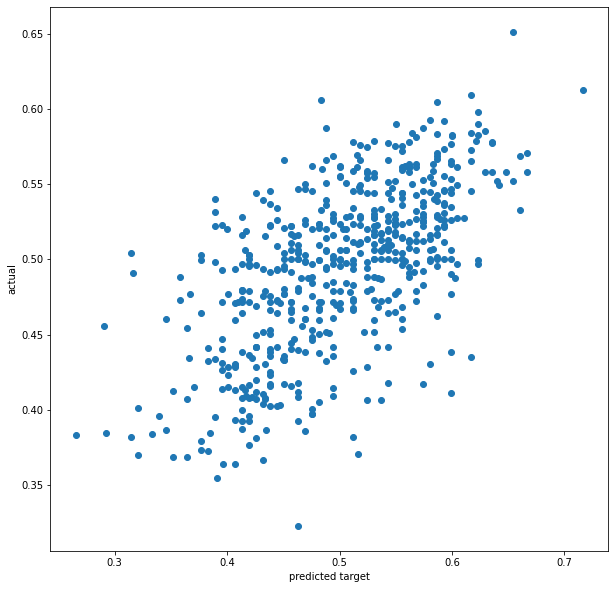

In [150]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('predicted target')
plt.ylabel('actual')
plt.show()

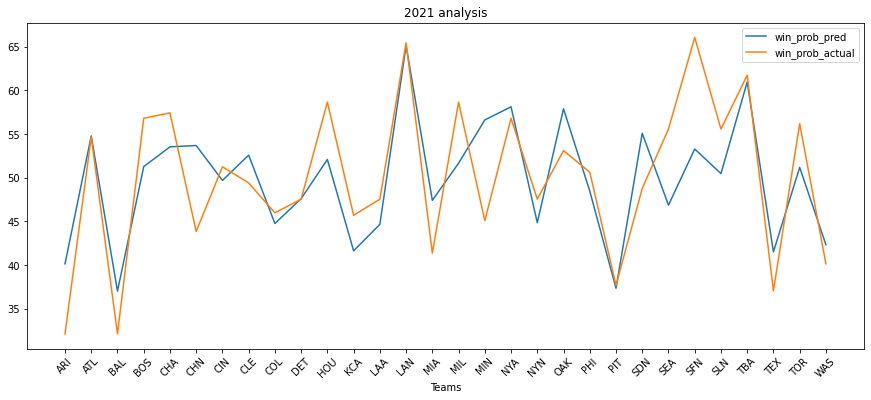

In [158]:
#@title graph for 2021 
result_df_2021 = result_df[result_df['yearID'] == 2021 ]
plt.figure(figsize = (15,6))
plt.plot(result_df_2021['teamID'], result_df_2021['win_prob_pred'], label = 'win_prob_pred')
plt.plot(result_df_2021['teamID'], result_df_2021['win_prob_actual'], label = 'win_prob_actual')
plt.title('2021 analysis')
plt.xlabel('Teams')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## other basic models 

In [85]:
imputer_mean = impute.SimpleImputer()
X_train_ = imputer_mean.fit_transform(X_train)
X_test_ = imputer_mean.transform(X_test)

In [86]:
#@title linear regression

reg1 = linear_model.LinearRegression()
reg1.fit(X_train_, y_train)
y_pred1 = reg1.predict(X_test_)
print(metrics.r2_score(y_test, y_pred1))

0.341971073352618


In [87]:
#@title decision tree
reg2 = tree.DecisionTreeRegressor()
reg2.fit(X_train_, y_train)
y_pred2 = reg2.predict(X_test_)
print(metrics.r2_score(y_test, y_pred2))

-0.34794073825518157
